In [1]:
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
from geoalchemy2 import Geometry, WKTElement
from shapely.geometry import Point

In [2]:
precinct_shapefile = gpd.read_file("/Users/codyschank/Dropbox/Insight/VTDs/VTDs.shp", encoding = 'utf-8')
#SRID is 3081, checked in QGIS
#project to geographic coordinates to match openaddresses
precinct_shapefile = precinct_shapefile.to_crs({'init': 'epsg:4326'})
precinct_shapefile.columns = map(str.lower, precinct_shapefile.columns)

In [3]:
precinct_shapefile.head()

,cnty,color,vtd,cntyvtd,vtdkey,shape_area,shape_len,e_ang,e_oth,e_hsp,e_total,e_vap,e_blak,e_bh,e_angvap,e_hspvap,e_bhvap,e_blakvap,e_othvap,geometry
0,53,2,0008,530008,1221,6.717692e+07,55772.006345,1117,19,131,1269,993,2,133,901,74,76,2,16,POLYGON ((-98.33433499967997 30.76611099985009...
1,469,2,0024,4690024,8511,5.426296e+07,50831.107001,1357,8,276,1679,1260,38,314,1044,179,209,30,7,POLYGON ((-96.99305200006546 28.92202500010095...
2,421,6,0302,4210302,7203,4.890835e+08,115435.448089,372,10,125,510,364,3,128,272,86,87,1,5,POLYGON ((-101.8275400003655 36.49963399957843...
3,479,1,0340,4790340,8622,1.949293e+06,5991.528062,336,87,2839,3274,2460,17,2851,275,2111,2118,10,67,POLYGON ((-99.47273100012492 27.57019099958216...
4,29,5,4046,294046,777,2.356032e+06,6851.937823,2038,225,1012,3644,3083,416,1381,1839,778,1057,301,187,POLYGON ((-98.43092700016071 29.51610299957829...


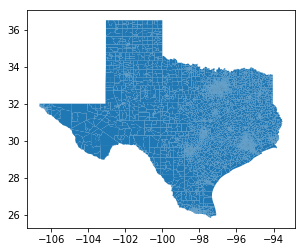

In [4]:
precinct_shapefile.plot()

In [5]:
# Define a database name (we're using a dataset on births, so we'll call it birth_db)
# Set your postgres username
dbname = 'map_the_vote'
username = 'codyschank' # change this to your username

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

postgres://codyschank@localhost/map_the_vote
True


In [6]:
# I don't know why this is necessary, but it is 
precinct_shapefile['geom'] = precinct_shapefile['geometry'].apply(lambda x: WKTElement(x.wkt, srid=4326))
precinct_shapefile.drop('geometry', 1, inplace=True)

In [7]:
table_name = "vtds_tx"
#had to run this from command line first: psql mydatabasename -c "CREATE EXTENSION postgis";
precinct_shapefile.to_sql(table_name, engine, if_exists='replace', index=False, 
                                dtype={'geom': Geometry('POLYGON', srid= 4326)})

In [8]:
con = None
con = psycopg2.connect(database = dbname, user = username)

# query:
sql_query = """
SELECT * FROM vtds_tx;
"""
precincts_from_sql = pd.read_sql_query(sql_query,con)
precincts_from_sql.head()


,cnty,color,vtd,cntyvtd,vtdkey,shape_area,shape_len,e_ang,e_oth,e_hsp,e_total,e_vap,e_blak,e_bh,e_angvap,e_hspvap,e_bhvap,e_blakvap,e_othvap,geom
0,53,2,0008,530008,1221,6.717692e+07,55772.006345,1117,19,131,1269,993,2,133,901,74,76,2,16,0103000020E610000001000000BC0300002762A0BE6595...
1,469,2,0024,4690024,8511,5.426296e+07,50831.107001,1357,8,276,1679,1260,38,314,1044,179,209,30,7,0103000020E6100000010000004E0200008CE0F9298E3F...
2,421,6,0302,4210302,7203,4.890835e+08,115435.448089,372,10,125,510,364,3,128,272,86,87,1,5,0103000020E6100000010000002E020000E86C556AF674...
3,479,1,0340,4790340,8622,1.949293e+06,5991.528062,336,87,2839,3274,2460,17,2851,275,2111,2118,10,67,0103000020E610000001000000BB000000E255863941DE...
4,29,5,4046,294046,777,2.356032e+06,6851.937823,2038,225,1012,3644,3083,416,1381,1839,778,1057,301,187,0103000020E6100000010000006B000000D529D74E949B...


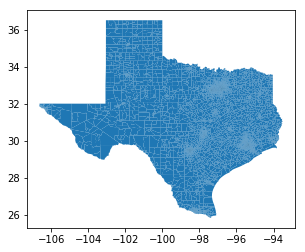

In [9]:
precincts_from_sql_gd = gpd.GeoDataFrame.from_postgis(sql_query, con, geom_col='geom')
precincts_from_sql_gd.plot()
plt.show()
